In [1]:
import time
notebook_start_time = time.time()

# 0. Setup

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0+cu124
tensorflow version: 2.18.0
pandas version: 2.2.2


# 1. Preparing the dataset



In [3]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [4]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- let's check the class distribution:

In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- now we should subsample the dataset so that we have a balanced dataset with the same number of data for `ham` and `spam`:

In [6]:
print("\n\n\n**********df['Label']**********:\n", df["Label"].head(5))

print("\n\n\n**********df['Label'] == 'spam'**********:\n", df["Label"].head(5) == "spam")

print("\n\n\n**********df[df['Label'] == 'spam']**********:\n", df[df["Label"] == "spam"].head(5))

print("\n\n\n**********df[df['Label'] == 'spam'].shape**********:\n", df[df["Label"] == "spam"].shape)





**********df['Label']**********:
 0     ham
1     ham
2    spam
3     ham
4     ham
Name: Label, dtype: object



**********df['Label'] == 'spam'**********:
 0    False
1    False
2     True
3    False
4    False
Name: Label, dtype: bool



**********df[df['Label'] == 'spam']**********:
    Label                                               Text
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...



**********df[df['Label'] == 'spam'].shape**********:
 (747, 2)


In [7]:
import numpy as np

def create_balanced_dataset(df):
  # count the instances of `spam`
  num_spam = df[df["Label"] == "spam"].shape[0]

  # randomly sub-sample "ham" with `num_spam` rows
  ham_sub = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

  # concatenate subsets
  balanced_df = pd.concat([ham_sub, df[df["Label"] == "spam"]])

  return balanced_df


balanced_df = create_balanced_dataset(df)

# show first 5 and last 5 rows
print(balanced_df.iloc[np.r_[0:5, -5:0]])

# check label/class distribution
print(balanced_df["Label"].value_counts())

     Label                                               Text
4307   ham  Awww dat is sweet! We can think of something t...
4138   ham                             Just got to  &lt;#&gt;
4831   ham  The word "Checkmate" in chess comes from the P...
4461   ham  This is wishing you a great day. Moji told me ...
5440   ham      Thank you. do you generally date the brothas?
5537  spam  Want explicit SEX in 30 secs? Ring 02073162414...
5540  spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547  spam  Had your contract mobile 11 Mnths? Latest Moto...
5566  spam  REMINDER FROM O2: To get 2.50 pounds free call...
5567  spam  This is the 2nd time we have tried 2 contact u...
Label
ham     747
spam    747
Name: count, dtype: int64


- Next, turn our "Label" into integer class labels:

In [8]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# show first 5 and last 5 rows
print(balanced_df.iloc[np.r_[0:5, -5:0]])

      Label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
5537      1  Want explicit SEX in 30 secs? Ring 02073162414...
5540      1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547      1  Had your contract mobile 11 Mnths? Latest Moto...
5566      1  REMINDER FROM O2: To get 2.50 pounds free call...
5567      1  This is the 2nd time we have tried 2 contact u...


- Now, let's split the dataset:

In [9]:
balanced_df.sample(frac=0.005, # fraction of the dataset to be subsample
                   random_state=211)

,Label,Text
5440,0,Thank you. do you generally date the brothas?
5251,0,"Yeah work is fine, started last week, all the ..."
1793,1,WIN: We have a winner! Mr. T. Foley won an iPo...
238,0,Where are you?when wil you reach here?
4371,1,Do you want a new Video handset? 750 any time ...
4678,0,Wewa is 130. Iriver 255. All 128 mb.
2295,1,You have 1 new message. Please call 08718738034.


In [10]:
balanced_df.sample(frac=0.005, random_state=211).reset_index(drop=True)

,Label,Text
0,0,Thank you. do you generally date the brothas?
1,0,"Yeah work is fine, started last week, all the ..."
2,1,WIN: We have a winner! Mr. T. Foley won an iPo...
3,0,Where are you?when wil you reach here?
4,1,Do you want a new Video handset? 750 any time ...
5,0,Wewa is 130. Iriver 255. All 128 mb.
6,1,You have 1 new message. Please call 08718738034.


In [11]:
def random_split(df, train_frac, validation_frac):

  # shuffle dataset
  df = df.sample(frac=1, random_state=211).reset_index(drop=True)

  # compute split range
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  # split
  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


# save splitted dataframe into csv files
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

# 2. Create DataLoaders

- But first, let's create a custom dataset:
1. We need a tokenizer
2. treat each line of the original raw dataset (aka `"Text"` column) as sequence of tokens
3. we should pad special tokens (aka `"<|endoftext|>"`) to every sequence so that it matches with the longest sequence or pre-defined `sequence length`

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))
print(tokenizer.decode([50256]))
print(tokenizer.n_vocab)

[50256]
<|endoftext|>
50257


In [13]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,
               csv_file,
               tokenizer,
               max_length=None,
               pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    # pre-tokenizer texts
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      # truncate sequences if they're longer than max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # pad tokens
    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]


  def __getitem__(self, index):
    encoded_sequence = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded_sequence, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    return max(len(encoded_text) for encoded_text in self.encoded_texts)

- Let's create our Datasets!!!

In [14]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

120


- Now create DataLoaders:

In [15]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(211)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [16]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [17]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


# 3. Initializing a model with pretrained weights

Let's reuse the code from the previous experiments:

In [18]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [19]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7cb2728314d0>)

In [20]:
from gpt_download import download_and_load_gpt2
import torch
import torch.nn as nn
import numpy as np



class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector








class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits





def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [21]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'124M'

In [22]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
print(settings)
print(params.keys())

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [23]:
model = GPT2Model(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

- Let's check whether the model generates coherent text:

In [24]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text


def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [25]:
text_1 = "In the midst of winter"

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    temperature = 2.0,
    top_k = 10
)

print(token_ids_to_text(token_ids, tokenizer))

In the midst of winter break I was sitting with two friends who I would call friends and would say 'I love you so so much. It's been really nice to see that you guys care.' It's been really nice for the rest of us." She's not exactly


- before finetuning, let's see whether the model can classify spam messages via prompting:

In [26]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


# 5. Adding a classification head

In [27]:
print(model)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_skip): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): Mult

In [28]:
!pip install torchinfo

In [29]:
from torchinfo import summary

summary(
    model,
    input_size=(1, BASE_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
GPT2Model (GPT2Model)                                   [1, 1024]                 [1, 1024, 50257]          --                        True
├─Embedding (token_emb): 1-1                            [1, 1024]                 [1, 1024, 768]            38,597,376                True
├─Embedding (position_emb): 1-2                         [1024]                    [1024, 768]               786,432                   True
├─Dropout (drop_emb): 1-3                               [1, 1024, 768]            [1, 1024, 768]            --                        --
├─Sequential (transformer_blocks): 1-4                  [1, 1024, 768]            [1, 1024, 768]            --                        True
│    └─TransformerBlock (0): 2-1                        [1, 1024, 768]            [1, 1024, 768]            --                        True
│    │    └─LayerNorm (l

- first, freeze all parameters:

In [30]:
for param in model.parameters():
    param.requires_grad = False

- and change the output layer `out_head` into `(out_head): Linear(in_features=768, out_features=2, bias=False)`

In [31]:
torch.manual_seed(211)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- we make the last transformer block and the final LayerNorm module connecting the last transformer block to the output layer trainable:

In [32]:
for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [33]:
#!pip install torchinfo

In [34]:
from torchinfo import summary

summary(
    model,
    input_size=(1, BASE_CONFIG["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Trainable
GPT2Model (GPT2Model)                                   [1, 1024]                 [1, 1024, 2]              --                        Partial
├─Embedding (token_emb): 1-1                            [1, 1024]                 [1, 1024, 768]            (38,597,376)              False
├─Embedding (position_emb): 1-2                         [1024]                    [1024, 768]               (786,432)                 False
├─Dropout (drop_emb): 1-3                               [1, 1024, 768]            [1, 1024, 768]            --                        --
├─Sequential (transformer_blocks): 1-4                  [1, 1024, 768]            [1, 1024, 768]            --                        Partial
│    └─TransformerBlock (0): 2-1                        [1, 1024, 768]            [1, 1024, 768]            --                        False
│    │    └─Lay

Let's see what has changed:

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inputs = tokenizer.encode("I open myself to")
inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0).to(device)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[  40, 1280, 3589,  284]], device='cuda:0')
Inputs dimensions: torch.Size([1, 4])


In [36]:
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-0.2085,  1.4101],
         [-0.9657,  5.2382],
         [ 0.1119,  4.5591],
         [ 0.3584,  5.9848]]], device='cuda:0')
Outputs dimensions: torch.Size([1, 4, 2])


In [37]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[0.3584, 5.9848]], device='cuda:0')


# 6. Calculating the classification loss and accuracy

In [38]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[0.3584, 5.9848]], device='cuda:0')


In [39]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


- since `softmax` is optional, we can also do:

In [40]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


- Let's create a classification accuracy function for the (pretrained or finetuned) model over the pre-defined number of batches in the dataloader:

In [41]:
def calc_accuracy_loader(data_loader,
                         model,
                         device,
                         num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      input_batch, label_batch = input_batch.to(device), label_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :] # logits of the last output token
      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == label_batch).sum().item()
    else:
      break
  return correct_predictions / num_examples

In [42]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [43]:
torch.manual_seed(211)


train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 51.25%
Validation accuracy: 58.75%
Test accuracy: 37.50%


- next, we define the cross-entropy loss function as a proxy for maximizing the classification accuracy for the (pretrained or finetuned) model over the pre-defined number of batches in the dataloader.

But first, let's calculate loss for each batch:

In [44]:
def calc_loss_batch(input_batch,
                    label_batch,
                    model,
                    device):
  input_batch, label_batch = input_batch.to(device), label_batch.to(device)
  logits = model(input_batch)[:, -1, :] # logits of the last output token
  loss = torch.nn.functional.cross_entropy(logits, label_batch)
  return loss

In [45]:
# same as pretraining
def calc_loss_loader(data_loader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for batch_id, (input_batch, label_batch) in enumerate(data_loader):
    if batch_id < num_batches:
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [46]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 1.851
Validation loss: 1.299
Test loss: 1.851


# 7. Finetuning the model on supervised data

- The `train_classifier_simple` function is the same as the `train_model_simple` function we used for pretraining the model.
- The only differences are:
  1. we track the number of training `examples_seen` instead of the number of tokens seen
  2. calculate the accuracy after each epoch instead of printing a sample text after each epoch

In [47]:
def train_classifier_simple(model,
                            train_loader,
                            val_loader,
                            optimizer,
                            device,
                            num_epochs,
                            eval_freq,
                            eval_iter # number of batches to evaluate from
                            ):
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, label_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, label_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0] # New: track examples instead of tokens
      global_step += 1


      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # calculate accuracy after each epoch
    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

  return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen

In [48]:
# same as pretraining
def evaluate_model(model,
                   train_loader,
                   val_loader,
                   device,
                   eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [49]:
import time

start_time = time.time()

torch.manual_seed(211)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.530, Val loss 1.177
Ep 1 (Step 000050): Train loss 0.637, Val loss 0.639
Ep 1 (Step 000100): Train loss 0.522, Val loss 0.533
Training accuracy: 80.00% | Validation accuracy: 87.50%
Ep 2 (Step 000150): Train loss 0.412, Val loss 0.336
Ep 2 (Step 000200): Train loss 0.224, Val loss 0.106
Ep 2 (Step 000250): Train loss 0.028, Val loss 0.070
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 3 (Step 000300): Train loss 0.124, Val loss 0.076
Ep 3 (Step 000350): Train loss 0.124, Val loss 0.048
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.075, Val loss 0.037
Ep 4 (Step 000450): Train loss 0.194, Val loss 0.043
Ep 4 (Step 000500): Train loss 0.171, Val loss 0.041
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.045, Val loss 0.037
Ep 5 (Step 000600): Train loss 0.021, Val loss 0.035
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train lo

- let's plot the loss function for the training and validation set:

In [50]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

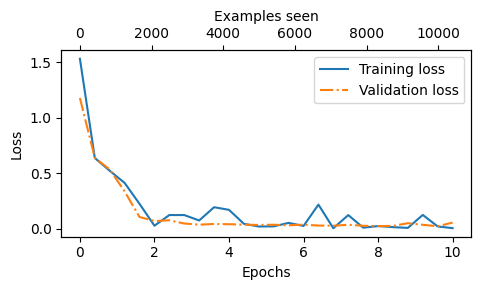

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- Let's plot the accuracy:

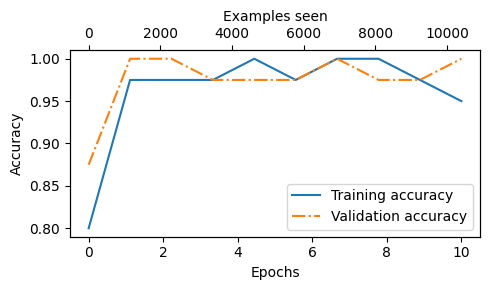

In [52]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- let's compute the training, validation, and test set performances over the complete dataset:

In [53]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.46%
Validation accuracy: 95.97%
Test accuracy: 96.33%


# 8. Using the LLM as a spam classifier

- let's create a function the uses our finetuned model to make prediction on the spam dataset:

In [54]:
def classify_review(text,
                    model,
                    tokenizer,
                    device,
                    max_length=None,
                    pad_token_id=50256):
  model.eval()

  # input preprocessing
  input_ids = tokenizer.encode(text)
  supported_context_length = model.position_emb.weight.shape[0]
  input_ids = input_ids[:min(max_length, supported_context_length)]
  input_ids += [pad_token_id] * (max_length  - len(input_ids))
  input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

  # model inference
  with torch.no_grad():
    logits = model(input_tensor)[:, -1, :] # logits of the last output token
  predicted_label = torch.argmax(logits, dim=-1).item()

  # return the classifier result
  return "spam" if predicted_label == 1 else "not spam"

In [55]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [56]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


Let's save the model:

In [57]:
torch.save(model.state_dict(), "review_classifier.pth")

and load it in another session:

In [58]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [59]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 0 min 56.81 sec
